In [17]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import matplotlib
import torch.nn.functional as F
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Import Data 

In [19]:
collocation_points = torch.load('../sample_data/u+collocation_points.pt')
bc_points = torch.load('../sample_data/u+boundary_points.pt')

x_train = collocation_points[0, :].view(-1, 1).to(device)
y_train = collocation_points[1, :].view(-1, 1).to(device)

u_train = collocation_points[2, :].view(-1, 1).to(device)
v_train = collocation_points[3, :].view(-1, 1).to(device)
p_train = collocation_points[4, :].view(-1, 1).to(device)


x_train_bc = bc_points[0, :].view(-1, 1).to(device)
y_train_bc = bc_points[1, :].view(-1, 1).to(device)

u_train_bc = bc_points[2, :].view(-1, 1).to(device)
v_train_bc = bc_points[3, :].view(-1, 1).to(device)
p_train_bc = bc_points[4, :].view(-1, 1).to(device)

print ("#collocation points:" , v_train.shape[0], "#boundary points:", v_train_bc.shape[0], "p_train_bc.max()=", p_train_bc.max())


#collocation points: 5589 #boundary points: 610 p_train_bc.max()= tensor(0.0977, device='cuda:0')


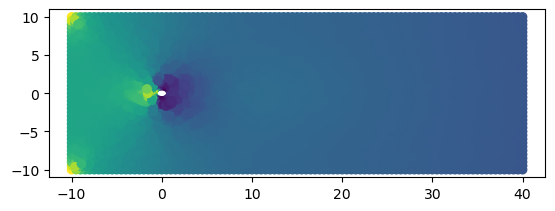

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1, adjustable='box', )
ax1.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=p_train.cpu().detach().numpy(), cmap="viridis")
plt.show()

### Format data

### Model

In [21]:
class PINN():


    def __init__(self, x, y,  u, v, p, bc_x, bc_y,  bc_u, bc_v, bc_p ):
        
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(y, dtype=torch.float32, requires_grad=True)
        self.bc_x = torch.tensor(bc_x, dtype=torch.float32, requires_grad=True)
        self.bc_y = torch.tensor(bc_y, dtype=torch.float32, requires_grad=True)
        
        
#         self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True)
        self.exact_u = torch.tensor(u, dtype=torch.float32, requires_grad=True)
        self.exact_v = torch.tensor(v, dtype=torch.float32, requires_grad=True)
        self.exact_p = torch.tensor(p, dtype=torch.float32, requires_grad=True)

        self.bc_exact_u = torch.tensor(bc_u, dtype=torch.float32, requires_grad=True)
        self.bc_exact_v = torch.tensor(bc_v, dtype=torch.float32, requires_grad=True)
        self.bc_exact_p = torch.tensor(bc_p, dtype=torch.float32, requires_grad=True)
        
        self.grouth_truth = torch.cat((u, v, p), 1)
        self.bc_grouth_truth = torch.cat((bc_u, bc_v, bc_p), 1)
        


        self.null = torch.zeros_like(self.x)

        self.neuralnet()

        #self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr= 0.01, max_iter= 10000, max_eval= 5000, history_size= 50, line_search_fn= 'strong_wolfe', tolerance_change= 0.5* np.finfo(float).eps, tolerance_grad= 1e-05)
        # self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.001)
        # self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=0.1, max_iter=200000, max_eval=50000,
        #                                    history_size=50, tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,
        #                                    line_search_fn="strong_wolfe")
        # self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr= 0.5, max_iter= 5_000)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.001)
        self.lr_schduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max = 50_000)
        
        self.mse = torch.nn.MSELoss()
        self.loss = 0
        self.losses = []
        self.best_loss = 1000
        self.iter = 0
        num_measure_data = 5000
        all_indices = torch.randperm(self.exact_u.size(0))
        self.indices = all_indices[:num_measure_data]

    def neuralnet(self):
        # hidden_size=20
        # self.net = torch.nn.Sequential(
        #     torch.nn.Linear(2, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, 3),  torch.nn.Tanh()).to(device)

        self.net = torch.nn.Sequential()
        dimension = 2
        hidden_layers = 20
        layer_neurons = 32
        layer_mat = [dimension] + hidden_layers * [layer_neurons] + [3]
        layer_num = len(layer_mat) - 1 
        for i in range(0, layer_num - 1):
            self.net.add_module(str(i) + "linear", nn.Linear(layer_mat[i], layer_mat[i + 1]))
            self.net.add_module(str(i) + "Act", nn.Tanh())  
        self.net.add_module(str(i) + "linear-last", nn.Linear(layer_mat[i+1], layer_mat[i + 2]))     
        # self.net.add_module(str(i) + "act-last", nn.Tanh())       
        self.net.to(device)
        
    def forward(self, x, y):
        X = torch.cat([x, y], 1).requires_grad_(True)
        result = self.net(X)
        u, v, p = result[:, 0:1], result[:, 1:2], result[:, 2:3]
        return u, v , p
    
    def navier_stokes(self, x, y):
        lambda_1, lambda_2 = 1., 0.02
        # result = self.net(torch.cat([x, y], 1))
        # psi, p = result[:, 0:1], result[:, 1:2]
        # u = torch.autograd.grad(psi, y, torch.ones_like(x), create_graph=True, )[0]
        # v = torch.autograd.grad(psi, x, torch.ones_like(y), create_graph=True, )[0]

        u, v, p = self.forward(x, y)
        p_x = torch.autograd.grad(p, x, torch.ones_like(x), create_graph=True,)[0]
        p_y = torch.autograd.grad(p, y, torch.ones_like(y), create_graph=True, )[0]

#         u_t = torch.autograd.grad(u, t, torch.ones_like(t), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(x), create_graph=True,)[0]
        u_y = torch.autograd.grad(u, y, torch.ones_like(y), create_graph=True, )[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(x), create_graph=True, )[0]
        u_yy = torch.autograd.grad(u_y, y, torch.ones_like(y), create_graph=True, )[0]

#         v_t = torch.autograd.grad(v, t, torch.ones_like(t), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(x), create_graph=True, )[0]
        v_y = torch.autograd.grad(v, y, torch.ones_like(y), create_graph=True, )[0]
        v_xx = torch.autograd.grad(v_x, x, torch.ones_like(x), create_graph=True,)[0]
        v_yy = torch.autograd.grad(v_y, y, torch.ones_like(y), create_graph=True,)[0]

        f_u = lambda_1 * (u*u_x + v*u_y) + p_x - lambda_2 * (u_xx + u_yy)
        f_v = lambda_1 * (u*v_x + v*v_y) + p_y - lambda_2 * (v_xx + v_yy)
        f_mass = u_x + v_y

        return u, v, p, f_u, f_v, f_mass, 
    
    def closure(self):
        self.optimizer.zero_grad()
        
        # collocation points only
        predicted_u, predicted_v, predicted_p, f_u_pred, f_v_pred, f_mass = self.navier_stokes(self.x, self.y)
        loss_f_u = self.mse(f_u_pred, torch.zeros_like(f_u_pred))
        loss_f_v = self.mse(f_v_pred, torch.zeros_like(f_v_pred))
        loss_f_mass = self.mse(f_mass, torch.zeros_like(f_mass))
        pde_loss =  loss_f_mass + loss_f_u + loss_f_v  

        
        # bc only
        bc_u, bc_v, bc_p  = self.forward(self.bc_x, self.bc_y)
        bc_mse_loss = F.mse_loss(torch.cat([bc_u, bc_v, bc_p], dim=1), self.bc_grouth_truth)

        # only for logging purpose., not included in the loss function!
        collocation_points_mse_loss = torch.nn.functional.mse_loss(torch.cat([predicted_u, predicted_v, predicted_p], dim=1), self.grouth_truth)
        measurement_data_loss = F.mse_loss(predicted_u[self.indices, :], self.exact_u[self.indices, :]) + \
              F.mse_loss(predicted_v[self.indices, :], self.exact_v[self.indices, :]) + \
                F.mse_loss(predicted_p[self.indices, :], self.exact_p[self.indices, :])
        

        self.loss =  pde_loss + bc_mse_loss #+ measurement_data_loss #+ pde_loss + bc_mse_loss 
        self.losses.append(self.loss)
        self.loss.backward()
        self.optimizer.step()
        self.lr_schduler.step()

        self.iter += 1
        if not self.iter % 1:            
            print("Iteration: {:} Total Loss: {:.6e},  PDE Loss: {:.6e}  Collocation Points/MSE Loss: {:.6f}, BC/MSE loss: {:.6f}".format(self.iter, self.loss, pde_loss, collocation_points_mse_loss, bc_mse_loss))

        return self.loss

    def train_nn(self):
        
        self.net.train()
        current_loss = self.closure()

        if current_loss < self.best_loss:
            self.best_loss = current_loss
            torch.save(self.net.state_dict(), f'pinn_navier_stokes+best.pth')

In [22]:
pinn_navier_stokes = PINN(x_train, y_train, u_train, v_train, p_train,
                          x_train_bc, y_train_bc, u_train_bc, v_train_bc, p_train_bc)
#pinn_navier_stokes.net.load_state_dict(torch.load(f'../pretrained_models/pinn_navier_stokes+0001.pth'))

In [23]:
pinn_navier_stokes.net

Sequential(
  (0linear): Linear(in_features=2, out_features=32, bias=True)
  (0Act): Tanh()
  (1linear): Linear(in_features=32, out_features=32, bias=True)
  (1Act): Tanh()
  (2linear): Linear(in_features=32, out_features=32, bias=True)
  (2Act): Tanh()
  (3linear): Linear(in_features=32, out_features=32, bias=True)
  (3Act): Tanh()
  (4linear): Linear(in_features=32, out_features=32, bias=True)
  (4Act): Tanh()
  (5linear): Linear(in_features=32, out_features=32, bias=True)
  (5Act): Tanh()
  (6linear): Linear(in_features=32, out_features=32, bias=True)
  (6Act): Tanh()
  (7linear): Linear(in_features=32, out_features=32, bias=True)
  (7Act): Tanh()
  (8linear): Linear(in_features=32, out_features=32, bias=True)
  (8Act): Tanh()
  (9linear): Linear(in_features=32, out_features=32, bias=True)
  (9Act): Tanh()
  (10linear): Linear(in_features=32, out_features=32, bias=True)
  (10Act): Tanh()
  (11linear): Linear(in_features=32, out_features=32, bias=True)
  (11Act): Tanh()
  (12linear):

In [24]:
#pinn_navier_stokes.optimizer=torch.optim.Adam(pinn_navier_stokes.net.parameters(), lr=0.0001)

In [ ]:
N_train = 50000
for _ in range(N_train):
    pinn_navier_stokes.train_nn()

In [26]:
# LBFGS Training
pinn_navier_stokes.train_nn()

Iteration: 50001 Total Loss: 1.016137e-04,  PDE Loss: 1.153133e-06  Collocation Points/MSE Loss: 0.000046, BC/MSE loss: 0.000100


In [27]:
pinn = PINN(x_train, y_train,   u_train, v_train, p_train, x_train_bc, y_train_bc,   u_train_bc, v_train_bc, p_train_bc)
pinn.net.load_state_dict(torch.load(f'pinn_navier_stokes+best.pth'))
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
predicted_u, predicted_v, predicted_p, _, _, _,  = pinn.navier_stokes(x_train, y_train)
mse_loss = torch.nn.functional.mse_loss(torch.cat([predicted_u, predicted_v, predicted_p], dim=1), torch.cat((u_train, v_train, p_train), 1))
print("MSE Loss: {:.6f}".format(mse_loss))

MSE Loss: 0.000046


In [28]:
case_id = "test"
torch.save(pinn_navier_stokes.net.state_dict(), f'pinn_navier_stokes+{case_id}.pth')
pinn = PINN(x_train, y_train,   u_train, v_train, p_train, x_train_bc, y_train_bc,   u_train_bc, v_train_bc, p_train_bc)
pinn.net.load_state_dict(torch.load(f'pinn_navier_stokes+{case_id}.pth'))
pinn.net.eval()
print ("Save model's weights + re-load: done!")
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
predicted_u, predicted_v, predicted_p, _, _, _,  = pinn.navier_stokes(x_train, y_train)
mse_loss = torch.nn.functional.mse_loss(torch.cat([predicted_u, predicted_v, predicted_p], dim=1), torch.cat((u_train, v_train, p_train), 1))
print("MSE Loss: {:.6f}".format(mse_loss))

Save model's weights + re-load: done!
MSE Loss: 0.000046


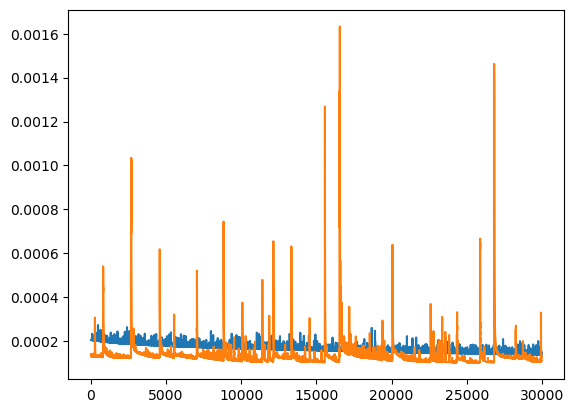

In [29]:
losses_vanilla  = np.load('losses_vanilla.npy')
losses_vanilla_0_0001  = np.load('losses_vanilla_lr0.001.npy')

plt.plot(losses_vanilla[20000:])
plt.plot(losses_vanilla_0_0001[20000:])

plt.show()

## Result Visualization

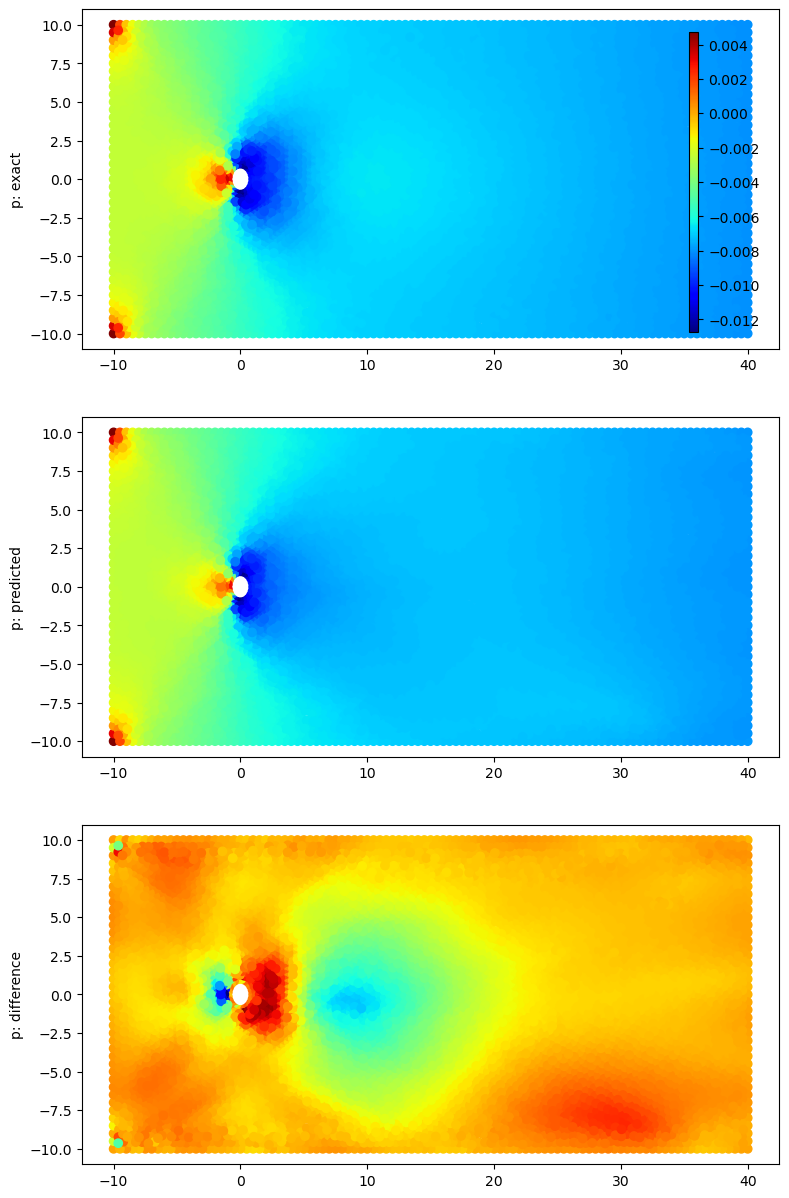

In [30]:
fig = plt.figure(figsize=(9, 15))
ax1 = fig.add_subplot(3,1,1, adjustable='box', )
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

im1= ax1.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=p_train.cpu().detach().numpy()[:74152], cmap="jet")
im2= ax2.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=predicted_p.cpu().detach().numpy(), cmap="jet")
im3= ax3.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=(predicted_p-p_train).cpu().detach().numpy(), cmap="jet")

# plt.xlabel('x')
ax1.set_ylabel('p: exact')
ax2.set_ylabel('p: predicted')
ax3.set_ylabel('p: difference')
cax = fig.add_axes([0.8, 0.665, 0.01, 0.2])
fig.colorbar(im1, cax=cax, orientation='vertical')
fig.colorbar(im2, cax=cax, orientation='vertical')
fig.colorbar(im3, cax=cax, orientation='vertical')

plt.show()

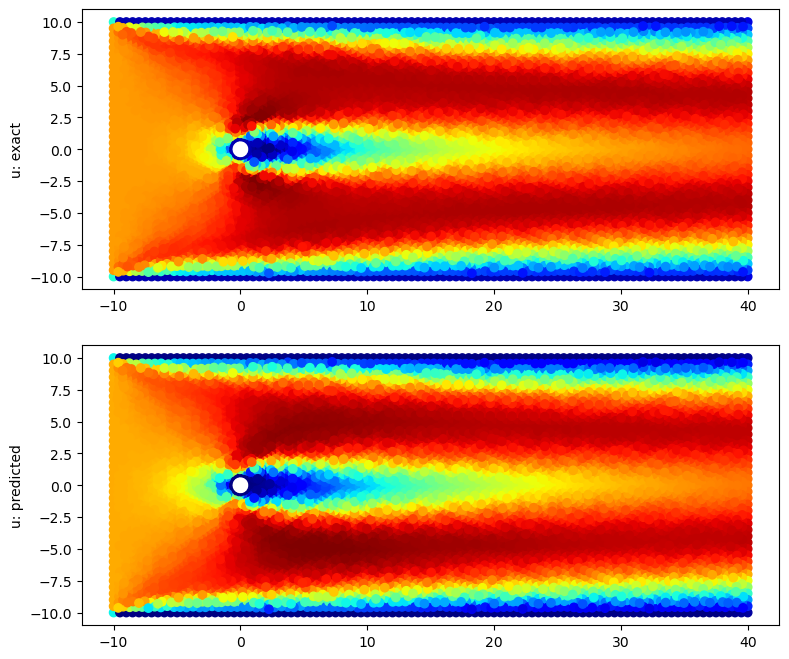

In [31]:
fig = plt.figure(figsize=(9, 8))
ax1 = fig.add_subplot(2,1,1, adjustable='box', )
ax2 = fig.add_subplot(2,1,2)

ax1.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=u_train.cpu()[:74152], cmap="jet", label="Exact")
ax2.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=predicted_u.cpu().detach().numpy(), cmap="jet", label="Predicted")
ax1.set_ylabel('u: exact')
ax2.set_ylabel('u: predicted')
plt.show()

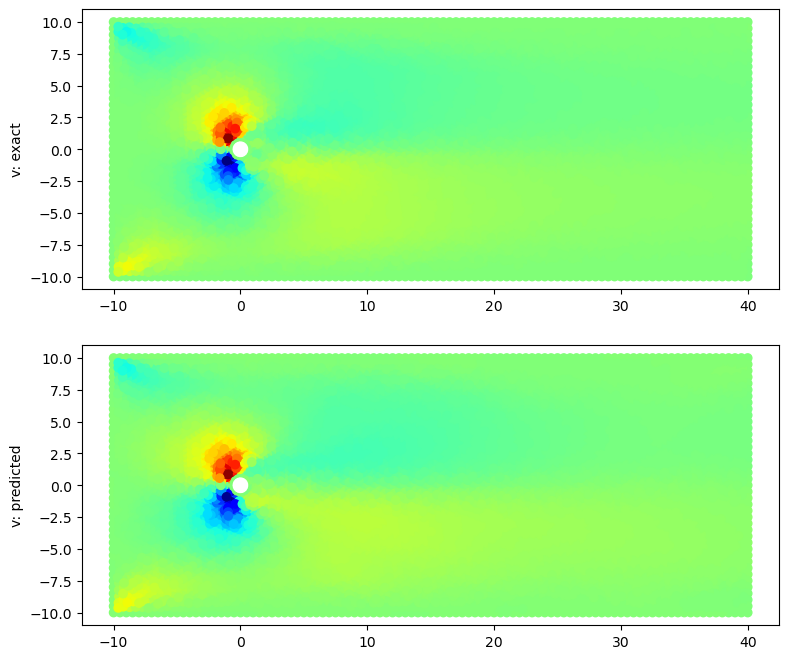

In [32]:
fig = plt.figure(figsize=(9, 8))
ax1 = fig.add_subplot(2,1,1, adjustable='box', )
ax2 = fig.add_subplot(2,1,2)

ax1.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=v_train.cpu()[:74152], cmap="jet", label="Exact")
ax2.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=predicted_v.cpu().detach().numpy(), cmap="jet", label="Predicted")
ax1.set_ylabel('v: exact')
ax2.set_ylabel('v: predicted')
plt.show()